In [1]:
# import dependencies in google colab
import os
# find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
spark_version = 'spark-3.4.3'
os.environ['SPARK_VERSION'] = spark_version

# install spark and java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# set environment variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [2]:
# import packages
from pyspark.sql import SparkSession
import time

# create SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [3]:
# mount google drive to collaboratory
from google.colab import drive
drive.mount('/content/gdrive')

# read in csv into a data frame
from pyspark import SparkFiles
dog_breeds_df = spark.read.format("csv").option('header', 'true').load('gdrive/My Drive/dog_breeds.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# preview dataframe
dog_breeds_df.show(10)

+------------------+-----------------+--------------------+-----------+-------------+---------------+--------------------+----------------------+
|             Breed|Country of Origin|           Fur Color|Height (in)|Color of Eyes|Longevity (yrs)|    Character Traits|Common Health Problems|
+------------------+-----------------+--------------------+-----------+-------------+---------------+--------------------+----------------------+
|Labrador Retriever|           Canada|Yellow, Black, Ch...|      21-24|        Brown|          10-12|Loyal, friendly, ...|  Hip dysplasia, ob...|
|   German Shepherd|          Germany|          Black, Tan|      22-26|        Brown|           7-10|Loyal, intelligen...|  Hip dysplasia, el...|
|           Bulldog|          England|          White, Red|      12-16|        Brown|           8-10|Loyal, calm, gent...|  Skin allergies, r...|
|            Poodle|           France|White, Black, Bro...|      10-15|  Brown, Blue|          12-15|Intelligent, acti...|  

# **Cleaning Data**

In [5]:
# convert character traits and common health problems columns to lower case
from pyspark.sql.functions import lower
dog_breeds_lower_df = dog_breeds_df.withColumn('character_traits', lower(dog_breeds_df['Character Traits']))\
                                   .withColumn('common_health_problems', lower(dog_breeds_df['Common Health Problems']))

# drop original columns
dog_breeds_lower_df = dog_breeds_lower_df.drop('Character Traits', 'Common Health Problems')

# display results
dog_breeds_lower_df.show(5)

+------------------+-----------------+--------------------+-----------+-------------+---------------+--------------------+----------------------+
|             Breed|Country of Origin|           Fur Color|Height (in)|Color of Eyes|Longevity (yrs)|    character_traits|common_health_problems|
+------------------+-----------------+--------------------+-----------+-------------+---------------+--------------------+----------------------+
|Labrador Retriever|           Canada|Yellow, Black, Ch...|      21-24|        Brown|          10-12|loyal, friendly, ...|  hip dysplasia, ob...|
|   German Shepherd|          Germany|          Black, Tan|      22-26|        Brown|           7-10|loyal, intelligen...|  hip dysplasia, el...|
|           Bulldog|          England|          White, Red|      12-16|        Brown|           8-10|loyal, calm, gent...|  skin allergies, r...|
|            Poodle|           France|White, Black, Bro...|      10-15|  Brown, Blue|          12-15|intelligent, acti...|  

In [6]:
# snake case all columns for sql
from pyspark.sql.functions import col
def to_snake_case(s):
  return s.replace(' ', '_').lower()

# rename all columns to snake case
dog_breeds_scase_df = dog_breeds_lower_df.select([col(col_name).alias(to_snake_case(col_name))\
                                                  for col_name in dog_breeds_lower_df.columns])

# display results
dog_breeds_scase_df.show()

+-------------------+-----------------+--------------------+-----------+-------------+---------------+--------------------+----------------------+
|              breed|country_of_origin|           fur_color|height_(in)|color_of_eyes|longevity_(yrs)|    character_traits|common_health_problems|
+-------------------+-----------------+--------------------+-----------+-------------+---------------+--------------------+----------------------+
| Labrador Retriever|           Canada|Yellow, Black, Ch...|      21-24|        Brown|          10-12|loyal, friendly, ...|  hip dysplasia, ob...|
|    German Shepherd|          Germany|          Black, Tan|      22-26|        Brown|           7-10|loyal, intelligen...|  hip dysplasia, el...|
|            Bulldog|          England|          White, Red|      12-16|        Brown|           8-10|loyal, calm, gent...|  skin allergies, r...|
|             Poodle|           France|White, Black, Bro...|      10-15|  Brown, Blue|          12-15|intelligent, act

In [7]:
# split the values in the character_traits and common_health_problems columns
from pyspark.sql.functions import explode, split

# columns to split or transform
col_to_transform = ['character_traits', 'common_health_problems']

# store unique values from columns
distinct_values = set()

# iterate over columns
for c in col_to_transform:
  # split values into array using comma as delimiter
  # explode array into a separate row
  split_col = dog_breeds_scase_df.select(explode(split(dog_breeds_scase_df[c], ', '))).distinct()
  # get distinct values
  distinct_values.update(split_col.select("col").collect())

# delete duplicates and sort distinct values
distinct_values = sorted(distinct_values)

# display distinct values
distinct_values[:5]

[Row(col='active'),
 Row(col='affectionate'),
 Row(col='athletic'),
 Row(col='bladder stones'),
 Row(col='brave')]

In [8]:
for i in distinct_values:
  print(i.col)

active
affectionate
athletic
bladder stones
brave
breathing problems
calm
cancer
charming
confident
curious
dental problems
diabetes
ear infections
elbow dysplasia
energetic
epilepsy
eye issues
eye problems
friendly
gentle
good-natured
heart conditions
hereditary myopathy
hip dysplasia
hypoallergenic
independent
intelligent
intervertebral disc disease
kind
loyal
obesity
pancreatitis
patient
playful
protective
respiratory issues
sensitive
skin allergies
social
strong
trainable


In [9]:
# columns to transform
col_to_transform = ['character_traits', 'common_health_problems']

# create conditional expressions for the distinct values
exprs = []
for value in distinct_values:
    for column_name in col_to_transform:
        exprs.append(f"CASE WHEN CAST({column_name} AS STRING) LIKE '%{value.col}%' THEN 1 ELSE 0 END AS {column_name}_{value.col.replace(' ', '_').replace('-', '_')}")

# concat conditonal expressions
sql_expr = ", ".join(exprs)

# create new column in dataframe
transformed_df = dog_breeds_scase_df.selectExpr(["*"]+ exprs)

# display results
transformed_df.show()

+-------------------+-----------------+--------------------+-----------+-------------+---------------+--------------------+----------------------+-----------------------+-----------------------------+-----------------------------+-----------------------------------+-------------------------+-------------------------------+-------------------------------+-------------------------------------+----------------------+----------------------------+-----------------------------------+-----------------------------------------+---------------------+---------------------------+-----------------------+-----------------------------+-------------------------+-------------------------------+--------------------------+--------------------------------+------------------------+------------------------------+--------------------------------+--------------------------------------+-------------------------+-------------------------------+-------------------------------+------------------------------------

In [10]:
# since the columns are duplicated for each distinct value
# find another way to create new binary columns

from pyspark.sql.functions import concat, expr

# split the values in the character_traits and common_health_problems columns
# columns to split or transform
col_to_transform = ['character_traits', 'common_health_problems']

# store unique values from columns
distinct_values = set()

# iterate over columns
for c in col_to_transform:
    # split values into array using comma as delimiter
    # explode array into a separate row
    split_col = dog_breeds_scase_df.selectExpr(f"explode(split({c}, ', ')) as col").distinct()
    # get distinct values
    distinct_values.update(split_col.rdd.map(lambda row: row.col).collect())

In [11]:
# create conditional expressions for the distinct values
exprs = []

for value in distinct_values:
    # Create a single transformation expression for each distinct value
    expr_for_value = []
    for column_name in col_to_transform:
        # Check if the value exists in the current column
         expr_for_value.append(expr(f"CASE WHEN {column_name} LIKE '%{value}%' THEN 1 ELSE 0 END"))
    # Concatenate the conditional expressions for the current value
    exprs.append(concat(*expr_for_value).alias(f"{value.replace(' ', '_').replace('-', '_')}"))

# create new columns in dataframe
transformed_df = dog_breeds_scase_df.select("*", *exprs)

# display results
transformed_df.show()

+-------------------+-----------------+--------------------+-----------+-------------+---------------+--------------------+----------------------+------+-------------+---------+--------+------------------+---------------+----+---------------+----------+-------+------+-------------------+-----------+--------------+-------+---------+--------+-------+--------+--------------+------------+------------+-----------+-------+----------+---------------------------+-----+-----+--------+--------+------+------------+---------+--------------+--------------+------------+------------------+----------------+---------+----+------+------+
|              breed|country_of_origin|           fur_color|height_(in)|color_of_eyes|longevity_(yrs)|    character_traits|common_health_problems|social|hip_dysplasia|trainable|athletic|breathing_problems|elbow_dysplasia|calm|dental_problems|protective|patient|strong|hereditary_myopathy|intelligent|hypoallergenic|obesity|sensitive|charming|playful|epilepsy|skin_allergie

In [12]:
# replace 10 to 1, 01 to 1, and 00 to 0

from pyspark.sql.functions import regexp_replace

for column in transformed_df.columns:
    transformed_df = transformed_df.withColumn(column, regexp_replace(column, '10', '1'))
    transformed_df = transformed_df.withColumn(column, regexp_replace(column, '01', '1'))
    transformed_df = transformed_df.withColumn(column, regexp_replace(column, '00', '0'))

# display results
transformed_df.show()

+-------------------+-----------------+--------------------+-----------+-------------+---------------+--------------------+----------------------+------+-------------+---------+--------+------------------+---------------+----+---------------+----------+-------+------+-------------------+-----------+--------------+-------+---------+--------+-------+--------+--------------+------------+------------+-----------+-------+----------+---------------------------+-----+-----+--------+--------+------+------------+---------+--------------+--------------+------------+------------------+----------------+---------+----+------+------+
|              breed|country_of_origin|           fur_color|height_(in)|color_of_eyes|longevity_(yrs)|    character_traits|common_health_problems|social|hip_dysplasia|trainable|athletic|breathing_problems|elbow_dysplasia|calm|dental_problems|protective|patient|strong|hereditary_myopathy|intelligent|hypoallergenic|obesity|sensitive|charming|playful|epilepsy|skin_allergie

In [13]:
# import dependencies
from pyspark.sql.functions import approxCountDistinct, desc

# find distinct count
distinct_counts = transformed_df.agg(*(approxCountDistinct(c).alias(c) for c in transformed_df.columns))

# sort by descending
distinct_counts_sorted = distinct_counts.select(*[c for c in distinct_counts.columns]).orderBy(*[desc(c) for c in distinct_counts.columns])

# display results
distinct_counts_sorted.show()

/content/spark-3.4.3-bin-hadoop3/python/pyspark/sql/functions.py:2610: FutureWarning: Deprecated in 2.1, use approx_count_distinct instead.
  warnings.warn("Deprecated in 2.1, use approx_count_distinct instead.", FutureWarning)


+-----+-----------------+---------+-----------+-------------+---------------+----------------+----------------------+------+-------------+---------+--------+------------------+---------------+----+---------------+----------+-------+------+-------------------+-----------+--------------+-------+---------+--------+-------+--------+--------------+------------+------------+-----------+-------+----------+---------------------------+-----+-----+--------+--------+------+------------+---------+--------------+--------------+------------+------------------+----------------+---------+----+------+------+
|breed|country_of_origin|fur_color|height_(in)|color_of_eyes|longevity_(yrs)|character_traits|common_health_problems|social|hip_dysplasia|trainable|athletic|breathing_problems|elbow_dysplasia|calm|dental_problems|protective|patient|strong|hereditary_myopathy|intelligent|hypoallergenic|obesity|sensitive|charming|playful|epilepsy|skin_allergies|good_natured|eye_problems|independent|curious|eye_issues

In [14]:
print(dog_breeds_scase_df.columns)

['breed', 'country_of_origin', 'fur_color', 'height_(in)', 'color_of_eyes', 'longevity_(yrs)', 'character_traits', 'common_health_problems']


In [15]:
# split the character_traits so it's easier for sql
from pyspark.sql.functions import explode, split

# create a copy of dog_breeds_scase_df
copied_df = dog_breeds_scase_df.alias('copied_df')

# Explode the Character Traits column to create new rows for each trait
exploded_df = copied_df.withColumn("character_trait", explode(split(copied_df["character_traits"], ", ")))

# drop original column
traits_df = exploded_df.drop('character_traits')

traits_df.show()

+------------------+-----------------+--------------------+-----------+-------------+---------------+----------------------+---------------+
|             breed|country_of_origin|           fur_color|height_(in)|color_of_eyes|longevity_(yrs)|common_health_problems|character_trait|
+------------------+-----------------+--------------------+-----------+-------------+---------------+----------------------+---------------+
|Labrador Retriever|           Canada|Yellow, Black, Ch...|      21-24|        Brown|          10-12|  hip dysplasia, ob...|          loyal|
|Labrador Retriever|           Canada|Yellow, Black, Ch...|      21-24|        Brown|          10-12|  hip dysplasia, ob...|       friendly|
|Labrador Retriever|           Canada|Yellow, Black, Ch...|      21-24|        Brown|          10-12|  hip dysplasia, ob...|    intelligent|
|Labrador Retriever|           Canada|Yellow, Black, Ch...|      21-24|        Brown|          10-12|  hip dysplasia, ob...|      energetic|
|Labrador Ret

In [16]:
# do the same for common health problems
from pyspark.sql.functions import explode, split

# create a copy of dog_breeds_scase_df
copy_df = dog_breeds_scase_df.alias('copy_df')

# explode the common health problems column to create new rows for each trait
explode_df = copy_df.withColumn("common_health_problem", explode(split(copy_df["common_health_problems"], ", ")))

# drop original column"
health_df = explode_df.drop('common_health_problems')

health_df.show()

+------------------+-----------------+--------------------+-----------+-------------+---------------+--------------------+---------------------+
|             breed|country_of_origin|           fur_color|height_(in)|color_of_eyes|longevity_(yrs)|    character_traits|common_health_problem|
+------------------+-----------------+--------------------+-----------+-------------+---------------+--------------------+---------------------+
|Labrador Retriever|           Canada|Yellow, Black, Ch...|      21-24|        Brown|          10-12|loyal, friendly, ...|        hip dysplasia|
|Labrador Retriever|           Canada|Yellow, Black, Ch...|      21-24|        Brown|          10-12|loyal, friendly, ...|              obesity|
|Labrador Retriever|           Canada|Yellow, Black, Ch...|      21-24|        Brown|          10-12|loyal, friendly, ...|       ear infections|
|   German Shepherd|          Germany|          Black, Tan|      22-26|        Brown|           7-10|loyal, intelligen...|        

# **TemporaryViews for SQL Queries**

In [17]:
# create temp views for both dataframes
transformed_df.createOrReplaceTempView('dog_breeds')
traits_df.createOrReplaceTempView('traits')
health_df.createOrReplaceTempView('health')

In [18]:
# top 5 common character trait
start_time = time.time()

spark.sql("""
select character_trait, count(distinct *) as trait_count
from traits
group by character_trait
order by trait_count desc
limit 5
""").show()

# check the runtime for the query
print("--- %s seconds ---" % (time.time() - start_time))

+---------------+-----------+
|character_trait|trait_count|
+---------------+-----------+
|    intelligent|        107|
|   good-natured|         99|
|      energetic|         90|
|        playful|         58|
|          loyal|         43|
+---------------+-----------+

--- 1.4011385440826416 seconds ---


In [19]:
# top 5 common health problem
start_time = time.time()

spark.sql("""
select common_health_problem, count(distinct *) as problem_count
from health
group by common_health_problem
order by problem_count desc
limit 5
""").show()

print("--- %s seconds ---" % (time.time() - start_time))

+---------------------+-------------+
|common_health_problem|problem_count|
+---------------------+-------------+
|      dental problems|           81|
|       skin allergies|           77|
|           eye issues|           60|
|        hip dysplasia|           41|
|         eye problems|           26|
+---------------------+-------------+

--- 0.8332064151763916 seconds ---


In [20]:
# total count per country
start_time = time.time()

spark.sql("""
select country_of_origin, count(country_of_origin) as total_count
from dog_breeds
group by country_of_origin
order by total_count desc
limit 5
""").show()

print("--- %s seconds ---" % (time.time() - start_time))

+-----------------+-----------+
|country_of_origin|total_count|
+-----------------+-----------+
|          England|         24|
|          Germany|         13|
|           France|         10|
|        Australia|          9|
|         Scotland|          9|
+-----------------+-----------+

--- 1.0205464363098145 seconds ---


In [21]:
# top 5 longevity
start_time = time.time()

spark.sql("""
select breed, country_of_origin, `longevity_(yrs)` as longevity
from dog_breeds
order by cast(split(`longevity_(yrs)`, '-')[1] as int) desc
limit 5
""").show()

print("--- %s seconds ---" % (time.time() - start_time))

+--------------------+-----------------+---------+
|               breed|country_of_origin|longevity|
+--------------------+-----------------+---------+
|           Chihuahua|           Mexico|    12-20|
|     Chinese Crested|            China|    13-18|
|          Pomeranian|          Germany|    12-16|
|            Shih Tzu|            China|     1-16|
|West Highland Whi...|         Scotland|    12-16|
+--------------------+-----------------+---------+

--- 1.1257355213165283 seconds ---


# **SQL Queries using Cached Tables**



In [22]:
# cache tables used
tables = ['dog_breeds', 'traits', 'health']

for t in tables:
  spark.table(t).cache()

In [23]:
# check if tables are cached
tables = ['dog_breeds', 'traits', 'health']

for t in tables:
  if spark.catalog.isCached(t):
    print(f'{t} is cached.')
  else:
    print(f'{t} is not cached.')

dog_breeds is cached.
traits is cached.
health is cached.


In [24]:
# top 5 common character trait using cached data
start_time = time.time()

spark.sql("""
select character_trait, count(distinct *) as trait_count
from traits
group by character_trait
order by trait_count desc
limit 5
""").show()

# check the runtime for the query
print("--- %s seconds ---" % (time.time() - start_time))

+---------------+-----------+
|character_trait|trait_count|
+---------------+-----------+
|    intelligent|        107|
|   good-natured|         99|
|      energetic|         90|
|        playful|         58|
|          loyal|         43|
+---------------+-----------+

--- 1.305628776550293 seconds ---


In [25]:
# top 5 common health problem using cached data
start_time = time.time()

spark.sql("""
select common_health_problem, count(distinct *) as problem_count
from health
group by common_health_problem
order by problem_count desc
limit 5
""").show()

print("--- %s seconds ---" % (time.time() - start_time))

+---------------------+-------------+
|common_health_problem|problem_count|
+---------------------+-------------+
|      dental problems|           81|
|       skin allergies|           77|
|           eye issues|           60|
|        hip dysplasia|           41|
|         eye problems|           26|
+---------------------+-------------+

--- 0.9360332489013672 seconds ---


In [26]:
# check longevity using cached data
start_time = time.time()

spark.sql("""
select breed, country_of_origin, `longevity_(yrs)` as longevity
from dog_breeds
order by cast(split(`longevity_(yrs)`, '-')[1] as int) desc
limit 5
""").show()

print("--- %s seconds ---" % (time.time() - start_time))

+--------------------+-----------------+---------+
|               breed|country_of_origin|longevity|
+--------------------+-----------------+---------+
|           Chihuahua|           Mexico|    12-20|
|     Chinese Crested|            China|    13-18|
|          Pomeranian|          Germany|    12-16|
|            Shih Tzu|            China|     1-16|
|West Highland Whi...|         Scotland|    12-16|
+--------------------+-----------------+---------+

--- 1.450526475906372 seconds ---


# **SQL Queries using Parquet**

In [27]:
# partition by "breeds" field on formatted parquet traits data
traits_df.write.partitionBy('breed').parquet('p_traits', mode='overwrite')

In [28]:
# read the parquet formatted data
p_traits_df = spark.read.parquet('p_traits')

In [29]:
# create a temporary table for parquet data
p_traits_df.createOrReplaceTempView('p_traits')

In [30]:
# top 5 common character trait using parquet data
start_time = time.time()

spark.sql("""
select character_trait, count(distinct *) as trait_count
from p_traits
group by character_trait
order by trait_count desc
limit 5
""").show()

# check the runtime for the query
print("--- %s seconds ---" % (time.time() - start_time))

+---------------+-----------+
|character_trait|trait_count|
+---------------+-----------+
|    intelligent|        107|
|   good-natured|         99|
|      energetic|         90|
|        playful|         58|
|          loyal|         43|
+---------------+-----------+

--- 1.7371947765350342 seconds ---


In [31]:
# uncache traits temporary table
spark.sql('uncache table traits')

DataFrame[]

In [32]:
# partition by "breeds" field on formatted parquet common health problems data
health_df.write.partitionBy('breed').parquet('p_health', mode='overwrite')

# read the parquet formatted data
p_health_df = spark.read.parquet('p_health')

# create a temporary table for parquet data
p_health_df.createOrReplaceTempView('p_health')

In [33]:
# top 5 common health problem using parquet data
start_time = time.time()

spark.sql("""
select common_health_problem, count(distinct *) as problem_count
from p_health
group by common_health_problem
order by problem_count desc
limit 5
""").show()

print("--- %s seconds ---" % (time.time() - start_time))

+---------------------+-------------+
|common_health_problem|problem_count|
+---------------------+-------------+
|      dental problems|           81|
|       skin allergies|           77|
|           eye issues|           60|
|        hip dysplasia|           41|
|         eye problems|           26|
+---------------------+-------------+

--- 1.6582224369049072 seconds ---


In [34]:
# uncache health temporary table
spark.sql('uncache table health')

DataFrame[]

In [35]:
# partition by "breeds" field on formatted parquet dog breeds data
transformed_df.write.partitionBy('breed').parquet('p_dog_breeds', mode='overwrite')

# read the parquet formatted data
p_dog_breeds_df = spark.read.parquet('p_dog_breeds')

# create a temporary table for parquet data
p_dog_breeds_df.createOrReplaceTempView('p_dog_breeds')

In [36]:
# check longevity using parquet data
start_time = time.time()

spark.sql("""
select breed, country_of_origin, `longevity_(yrs)` as longevity
from p_dog_breeds
order by cast(split(`longevity_(yrs)`, '-')[1] as int) desc
limit 5
""").show()

print("--- %s seconds ---" % (time.time() - start_time))

+--------------------+-----------------+---------+
|               breed|country_of_origin|longevity|
+--------------------+-----------------+---------+
|           Chihuahua|           Mexico|    12-20|
|     Chinese Crested|            China|    13-18|
|          Pomeranian|          Germany|    12-16|
|West Highland Whi...|         Scotland|    12-16|
|Australian Cattle...|        Australia|    12-16|
+--------------------+-----------------+---------+

--- 0.9858283996582031 seconds ---


In [37]:
# uncache traits temporary table
spark.sql('uncache table dog_breeds')

DataFrame[]

In [38]:
# check if tables are no longer cached
tables = ['traits', 'health', 'dog_breeds']

for t in tables:
  if spark.catalog.isCached(t):
    print(f'{t} is cached.')
  else:
    print(f'{t} is not cached.')

traits is not cached.
health is not cached.
dog_breeds is not cached.


# **Cleaning Data for Binary Classification Models**

In [39]:
# create a linear regression model with the cleaned dataset with the binary classification values
transformed_df.show()

+-------------------+-----------------+--------------------+-----------+-------------+---------------+--------------------+----------------------+------+-------------+---------+--------+------------------+---------------+----+---------------+----------+-------+------+-------------------+-----------+--------------+-------+---------+--------+-------+--------+--------------+------------+------------+-----------+-------+----------+---------------------------+-----+-----+--------+--------+------+------------+---------+--------------+--------------+------------+------------------+----------------+---------+----+------+------+
|              breed|country_of_origin|           fur_color|height_(in)|color_of_eyes|longevity_(yrs)|    character_traits|common_health_problems|social|hip_dysplasia|trainable|athletic|breathing_problems|elbow_dysplasia|calm|dental_problems|protective|patient|strong|hereditary_myopathy|intelligent|hypoallergenic|obesity|sensitive|charming|playful|epilepsy|skin_allergie

In [40]:
from pyspark.sql.functions import when

# conditions to categorize longevity
conditions = [
    (transformed_df["longevity_(yrs)"].substr(-2, 2).cast("int") < 10),
    (transformed_df["longevity_(yrs)"].substr(-2, 2).cast("int").between(10, 13)),
    (transformed_df["longevity_(yrs)"].substr(-2, 2).cast("int") > 12)
]

# create a new column longevity(yrs)_class based on the conditions and numerical values
clean_df = transformed_df.withColumn("longevity(yrs)_class",
                                    when(conditions[0], 0)
                                    .when(conditions[1], 1)
                                    .when(conditions[2], 2)
                                    .otherwise("NA"))

# note: 0 = short-lived less than 10 years, 1 = medium-lived 10-13 years, 2 = 3 long-lived more than 12 years

# display the updated DataFrame
clean_df.show()

+-------------------+-----------------+--------------------+-----------+-------------+---------------+--------------------+----------------------+------+-------------+---------+--------+------------------+---------------+----+---------------+----------+-------+------+-------------------+-----------+--------------+-------+---------+--------+-------+--------+--------------+------------+------------+-----------+-------+----------+---------------------------+-----+-----+--------+--------+------+------------+---------+--------------+--------------+------------+------------------+----------------+---------+----+------+------+--------------------+
|              breed|country_of_origin|           fur_color|height_(in)|color_of_eyes|longevity_(yrs)|    character_traits|common_health_problems|social|hip_dysplasia|trainable|athletic|breathing_problems|elbow_dysplasia|calm|dental_problems|protective|patient|strong|hereditary_myopathy|intelligent|hypoallergenic|obesity|sensitive|charming|playful|e

In [41]:
print(clean_df.dtypes)

[('breed', 'string'), ('country_of_origin', 'string'), ('fur_color', 'string'), ('height_(in)', 'string'), ('color_of_eyes', 'string'), ('longevity_(yrs)', 'string'), ('character_traits', 'string'), ('common_health_problems', 'string'), ('social', 'string'), ('hip_dysplasia', 'string'), ('trainable', 'string'), ('athletic', 'string'), ('breathing_problems', 'string'), ('elbow_dysplasia', 'string'), ('calm', 'string'), ('dental_problems', 'string'), ('protective', 'string'), ('patient', 'string'), ('strong', 'string'), ('hereditary_myopathy', 'string'), ('intelligent', 'string'), ('hypoallergenic', 'string'), ('obesity', 'string'), ('sensitive', 'string'), ('charming', 'string'), ('playful', 'string'), ('epilepsy', 'string'), ('skin_allergies', 'string'), ('good_natured', 'string'), ('eye_problems', 'string'), ('independent', 'string'), ('curious', 'string'), ('eye_issues', 'string'), ('intervertebral_disc_disease', 'string'), ('brave', 'string'), ('loyal', 'string'), ('friendly', 'stri

In [42]:
# convert columns with integer values from string to int
from pyspark.sql.functions import col, when

def string_to_int(value):
    if value is None:
        return 0
    try:
        return int(value)
    except ValueError:
        return 0

def convert_to_int(column_name):
    return when(col(column_name) == "0", 0).otherwise(col(column_name).cast("int"))

int_columns = ['gentle',
 'eye_issues',
 'loyal',
 'hip_dysplasia',
 'affectionate',
 'brave',
 'playful',
 'bladder_stones',
 'confident',
 'epilepsy',
 'breathing_problems',
 'dental_problems',
 'ear_infections',
 'energetic',
 'athletic',
 'social',
 'curious',
 'hereditary_myopathy',
 'good_natured',
 'trainable',
 'pancreatitis',
 'heart_conditions',
 'intelligent',
 'hypoallergenic',
 'kind',
 'independent',
 'charming',
 'friendly',
 'elbow_dysplasia',
 'eye_problems',
 'protective',
 'calm',
 'skin_allergies',
 'sensitive',
 'intervertebral_disc_disease',
 'respiratory_issues',
 'active',
 'patient',
 'obesity',
 'diabetes',
 'strong',
 'cancer',
 'longevity(yrs)_class']

# convert string columns to integer
for col_name in int_columns:
    clean_df = clean_df.withColumn(col_name, convert_to_int(col_name))

# check dtypes
print(clean_df.dtypes)

[('breed', 'string'), ('country_of_origin', 'string'), ('fur_color', 'string'), ('height_(in)', 'string'), ('color_of_eyes', 'string'), ('longevity_(yrs)', 'string'), ('character_traits', 'string'), ('common_health_problems', 'string'), ('social', 'int'), ('hip_dysplasia', 'int'), ('trainable', 'int'), ('athletic', 'int'), ('breathing_problems', 'int'), ('elbow_dysplasia', 'int'), ('calm', 'int'), ('dental_problems', 'int'), ('protective', 'int'), ('patient', 'int'), ('strong', 'int'), ('hereditary_myopathy', 'int'), ('intelligent', 'int'), ('hypoallergenic', 'int'), ('obesity', 'int'), ('sensitive', 'int'), ('charming', 'int'), ('playful', 'int'), ('epilepsy', 'int'), ('skin_allergies', 'int'), ('good_natured', 'int'), ('eye_problems', 'int'), ('independent', 'int'), ('curious', 'int'), ('eye_issues', 'int'), ('intervertebral_disc_disease', 'int'), ('brave', 'int'), ('loyal', 'int'), ('friendly', 'int'), ('diabetes', 'int'), ('cancer', 'int'), ('pancreatitis', 'int'), ('confident', 'i

In [43]:
# import our dependencies
import pandas as pd

# first drop unncessary columns
col_to_drop = ['character_traits', 'common_health_problems', 'longevity_(yrs)']

df = clean_df.drop(*col_to_drop)

# convert spark dataframe to pandas dataframe
pandas_df = df.toPandas()

In [44]:
# convert categorical data to numeric with `pd.get_dummies`
numeric_app_df = pd.get_dummies(pandas_df)
numeric_app_df.head()

,social,hip_dysplasia,trainable,athletic,breathing_problems,elbow_dysplasia,calm,dental_problems,protective,patient,...,height_(in)_7-11,height_(in)_7-8,height_(in)_8-1,height_(in)_8-11,height_(in)_9-1,height_(in)_9-11,color_of_eyes_Blue,"color_of_eyes_Blue, Grey",color_of_eyes_Brown,"color_of_eyes_Brown, Blue"
0,0,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
1,0,1,1,0,0,1,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
2,0,0,0,0,0,0,1,0,0,0,...,False,False,False,False,False,False,False,False,True,False
3,0,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
4,0,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False


# **Neural Network Model**

In [45]:
# import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split data into features and target arrays
X = numeric_app_df.drop(columns='longevity(yrs)_class')
y = numeric_app_df['longevity(yrs)_class']

# split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [46]:
# create a StandardScaler instances
scaler = StandardScaler()

# fit the StandardScaler
X_scaler = scaler.fit(X_train)

# scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [47]:
# import dependencies
import tensorflow as tf

# define the neural network model
input_features = X_train_scaled.shape[1]
hidden_nodes_1 = 8
hidden_nodes_2 = 16
hidden_nodes_3 = 32

nn = tf.keras.models.Sequential()

# first hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_1, input_dim=input_features, activation='relu'))

# second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_2, activation='sigmoid'))
nn.add(tf.keras.layers.Dense(units=hidden_nodes_3, activation='sigmoid'))

# output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 2504      
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3225 (12.60 KB)
Trainable params: 3225 (12.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
# compile the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
# train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

Epoch 1/50
3/3 [==============================] - 1s 10ms/step - loss: 0.4017 - accuracy: 0.2069
Epoch 2/50
3/3 [==============================] - 0s 6ms/step - loss: 0.2935 - accuracy: 0.2069
Epoch 3/50
3/3 [==============================] - 0s 6ms/step - loss: 0.1866 - accuracy: 0.2069
Epoch 4/50
3/3 [==============================] - 0s 6ms/step - loss: 0.0795 - accuracy: 0.2069
Epoch 5/50
3/3 [==============================] - 0s 8ms/step - loss: -0.0238 - accuracy: 0.2069
Epoch 6/50
3/3 [==============================] - 0s 7ms/step - loss: -0.1227 - accuracy: 0.2069
Epoch 7/50
3/3 [==============================] - 0s 6ms/step - loss: -0.2221 - accuracy: 0.2069
Epoch 8/50
3/3 [==============================] - 0s 6ms/step - loss: -0.3170 - accuracy: 0.2069
Epoch 9/50
3/3 [==============================] - 0s 5ms/step - loss: -0.4114 - accuracy: 0.2069
Epoch 10/50
3/3 [==============================] - 0s 5ms/step - loss: -0.5039 - accuracy: 0.2069
Epoch 11/50
3/3 [===============

In [50]:
# evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1/1 - 0s - loss: -3.6601e+00 - accuracy: 0.2000 - 281ms/epoch - 281ms/step
Loss: -3.6601126194000244, Accuracy: 0.20000000298023224


# **Random Forest Model**

In [51]:
# try random forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# split data into features and target arrays
X = numeric_app_df.drop(columns='longevity(yrs)_class')
y = numeric_app_df['longevity(yrs)_class']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# train the classifier
rf_classifier.fit(X_train, y_train)

# make predictions on the test set
y_pred = rf_classifier.predict(X_test)

In [52]:
# calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9166666666666666


In [53]:
# confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

forest_cm = confusion_matrix(y_test, y_pred)

# labels for rows and columns
labels = ['Actual Negative', 'Actual Positive']
columns = ['Predicted Negative', 'Predicted Positive']

# print confusion matrix
print("{:<20} {:<20} {:<20}".format('', *columns))
for label, row in zip(labels, forest_cm):
    print("{:<20} {:<20} {:<20}".format(label, *row))

                     Predicted Negative   Predicted Positive  
Actual Negative      0                    1                   
Actual Positive      0                    0                   


In [54]:
# classificiation report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.96      1.00      0.98        22

    accuracy                           0.92        24
   macro avg       0.32      0.33      0.33        24
weighted avg       0.88      0.92      0.90        24



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


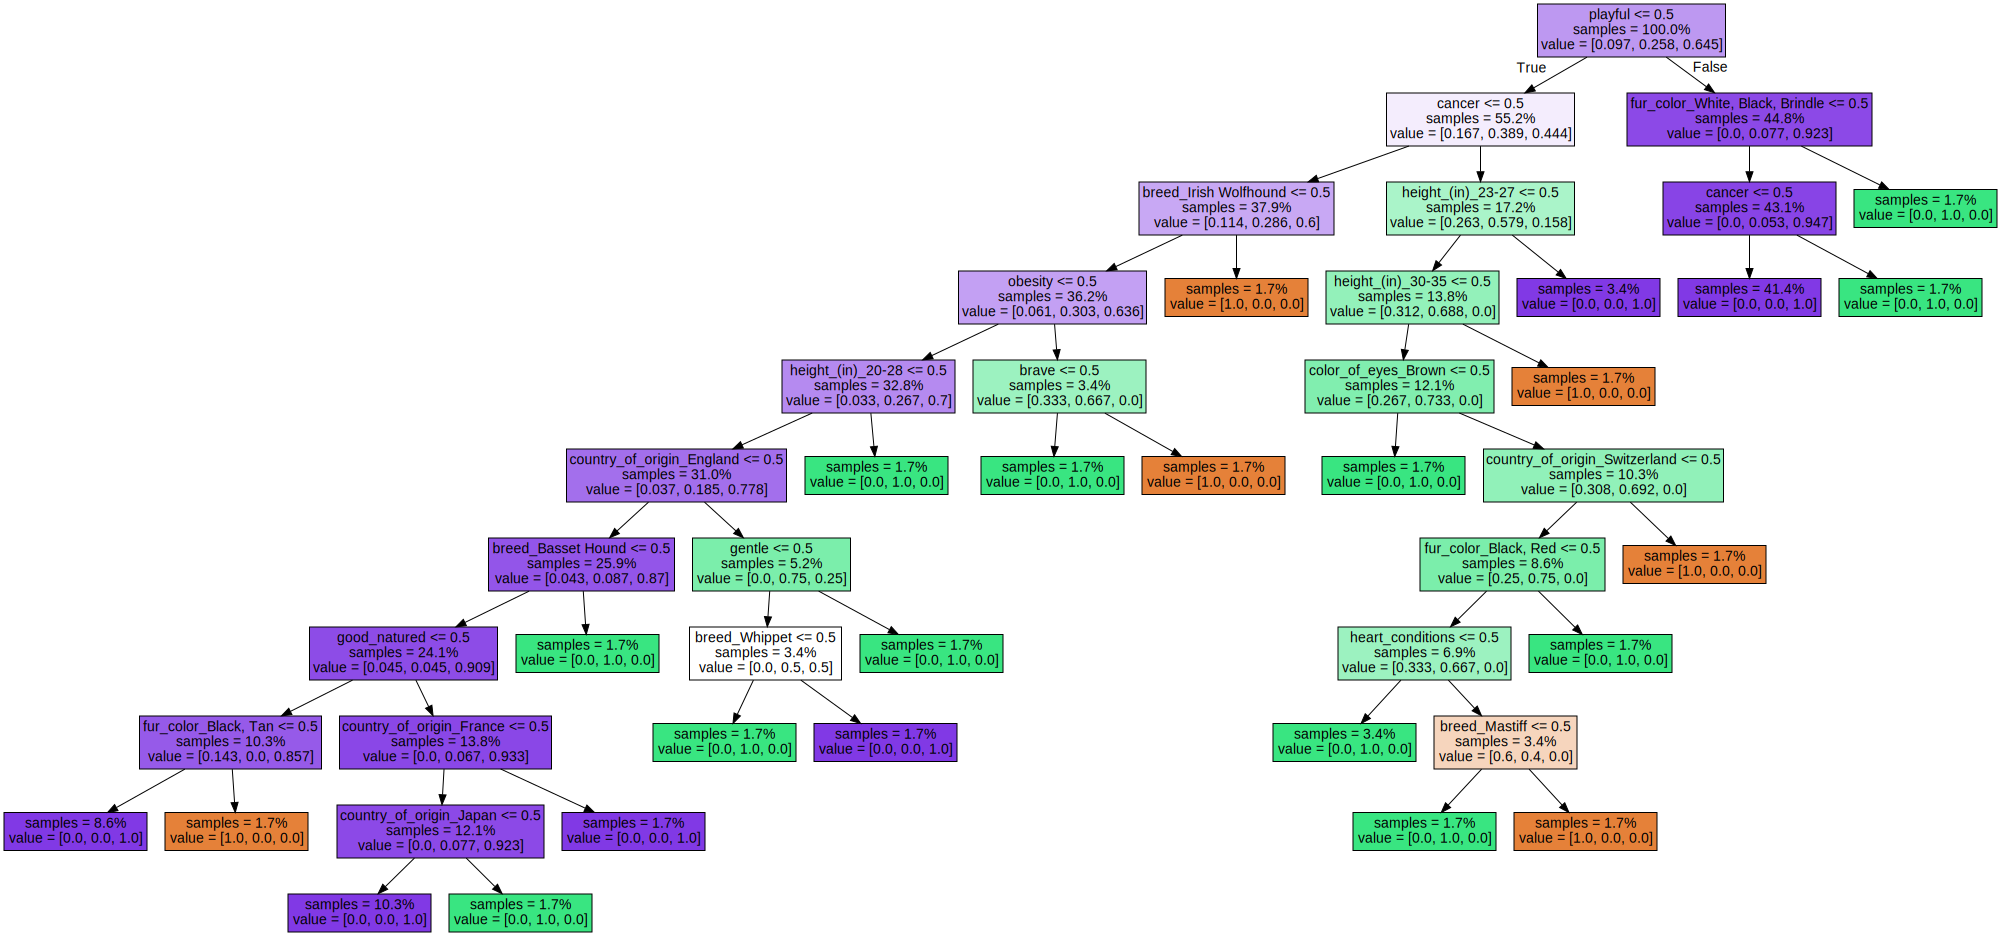

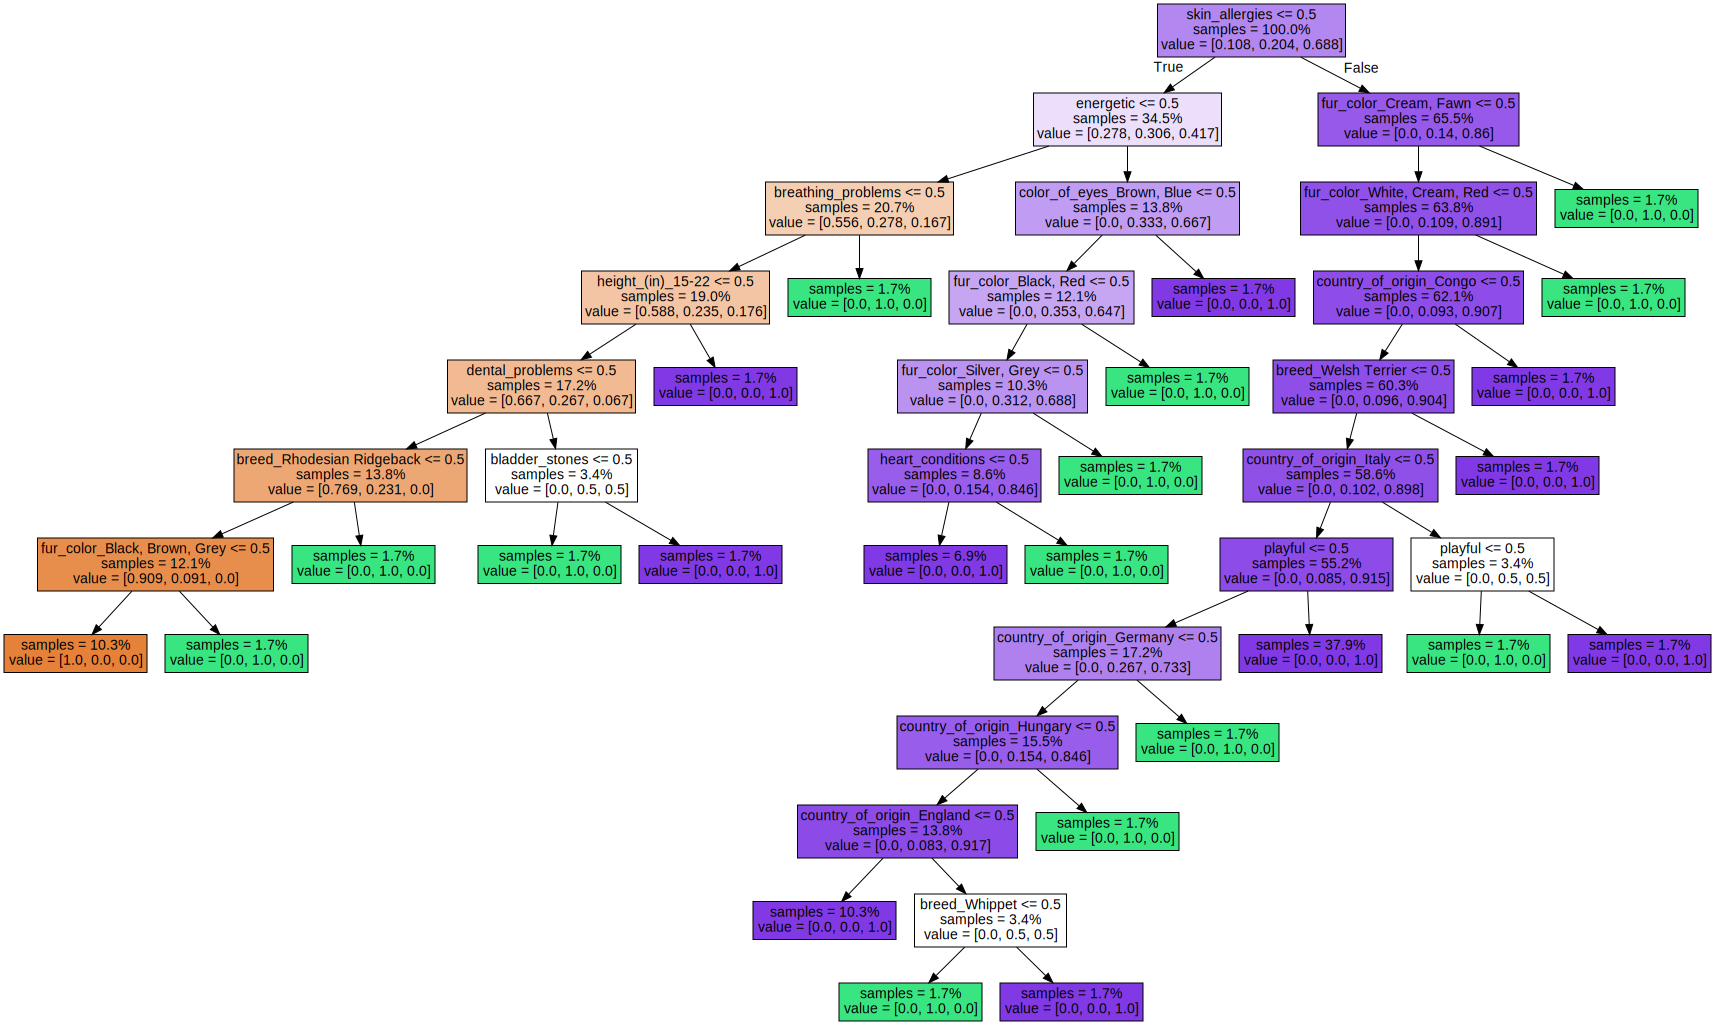

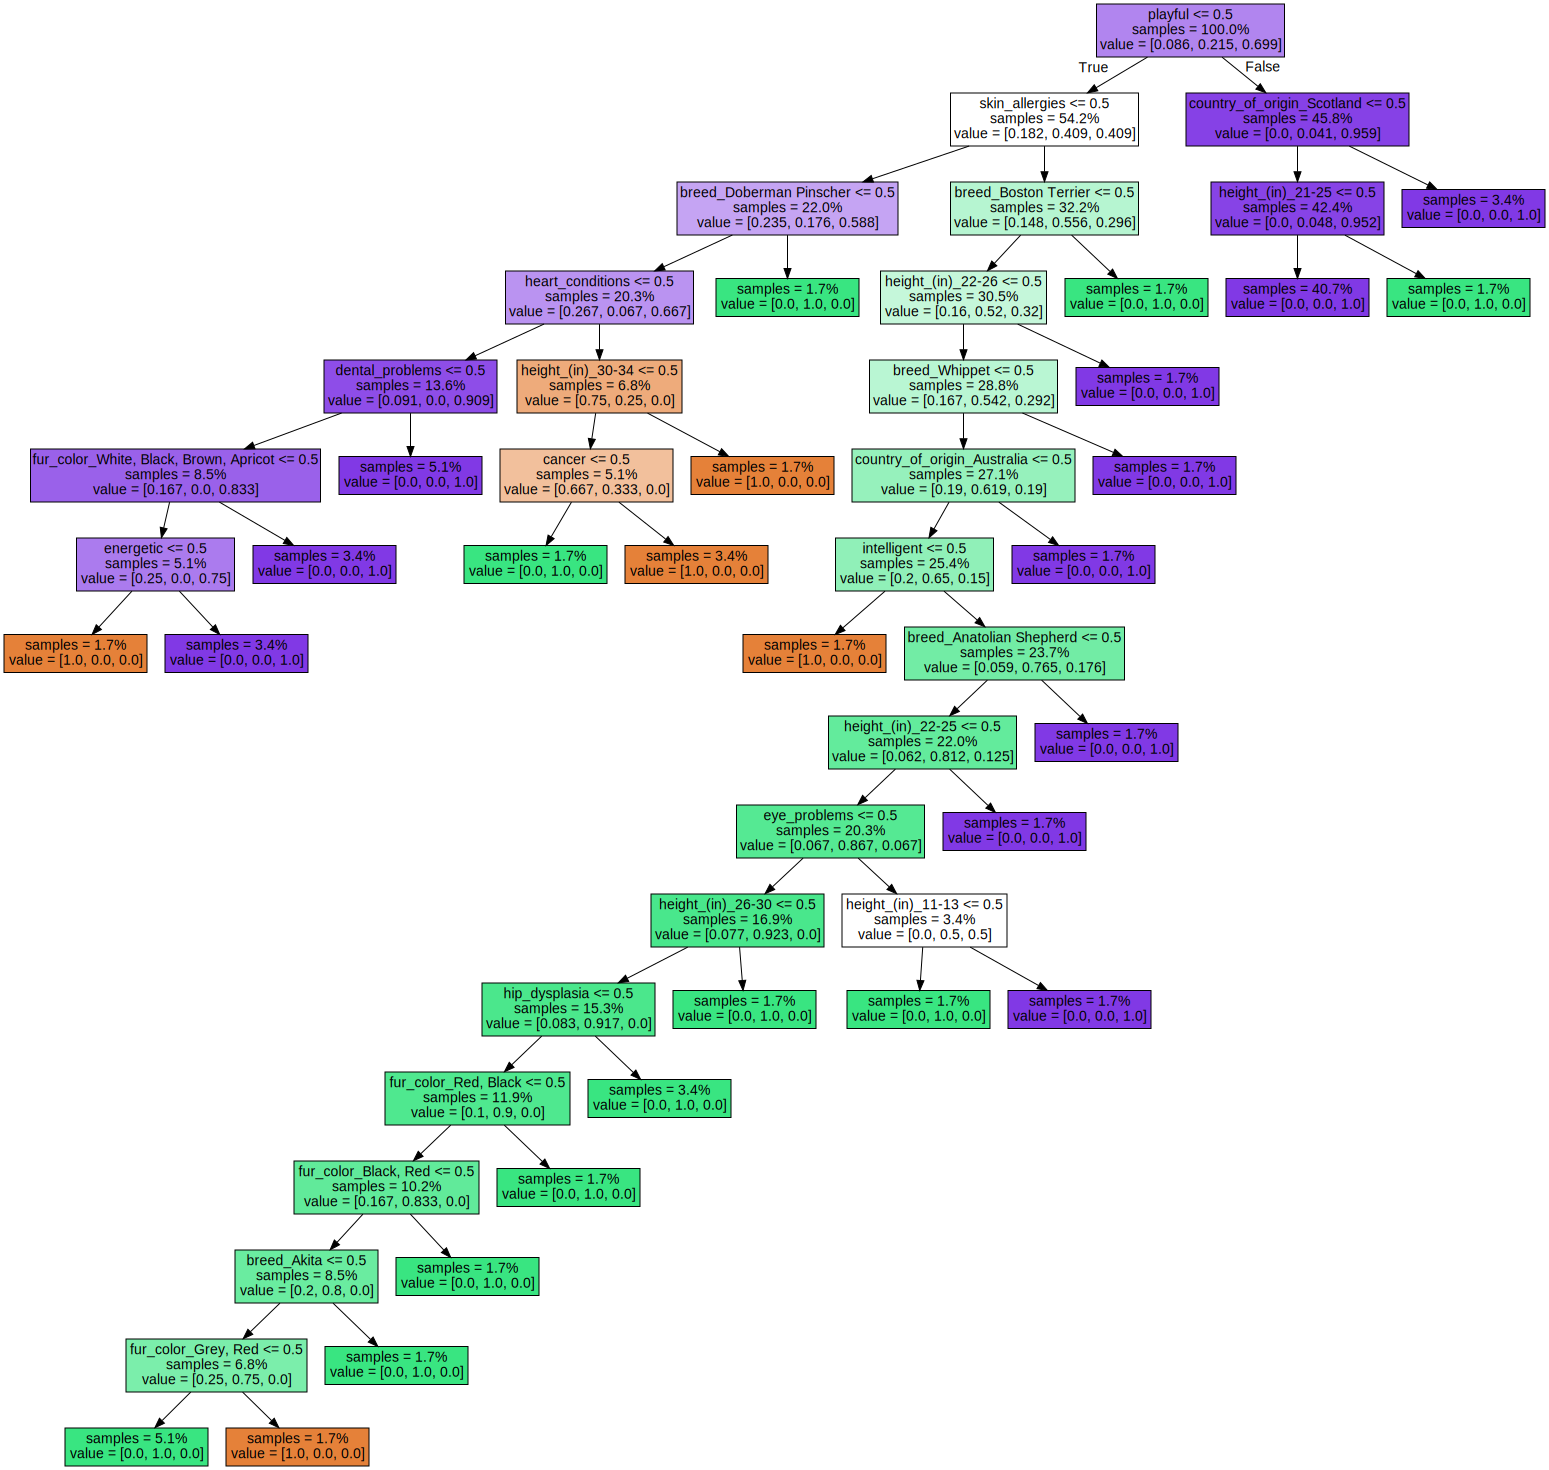

In [55]:
# tree visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# create a directory in Google Drive to save the png files
output_dir = "/content/gdrive/My Drive/tree_visualizations"
os.makedirs(output_dir, exist_ok=True)

# first three decision trees from the forest
for i, tree in enumerate(rf_classifier.estimators_[:3]):
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    output_file = os.path.join(output_dir, f"tree_{i}.png")
    graph.render(output_file, format='png', cleanup=True)
    display(graph)

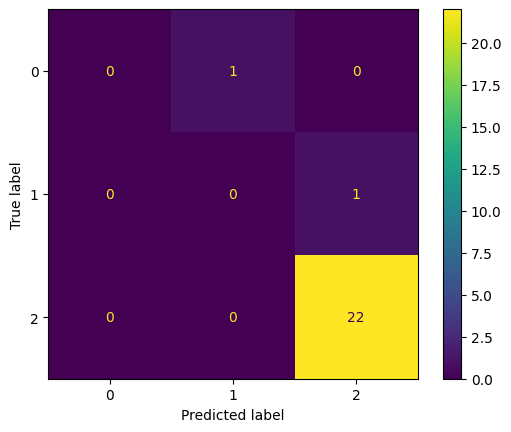

In [56]:
# visualize confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=forest_cm).plot();

# **Support Vector Model (SVM)**

In [65]:
# try support vector model (svm)
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split data into features and target arrays
X = numeric_app_df.drop(columns='longevity(yrs)_class')
y = numeric_app_df['longevity(yrs)_class']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# data preprocessing: feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# create svm model with a linear kernel
svm_model = svm.SVC(kernel='linear')

# train the svm model
svm_model.fit(X_train_scaled, y_train)

# make predictions on the testing set
y_pred = svm_model.predict(X_test_scaled)

In [66]:
#check model performance
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9583333333333334


In [67]:
# confusion matrix
from sklearn.metrics import confusion_matrix

svm_cm = confusion_matrix(y_test, y_pred)

# labels for rows and columns
labels = ['Actual Negative', 'Actual Positive']
columns = ['Predicted Negative', 'Predicted Positive']

# print confusion matrix
print("{:<20} {:<20} {:<20}".format('', *columns))
for label, row in zip(labels, svm_cm):
    print("{:<20} {:<20} {:<20}".format(label, *row))

                     Predicted Negative   Predicted Positive  
Actual Negative      0                    1                   
Actual Positive      0                    1                   


In [68]:
# classificiation report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1
           2       1.00      1.00      1.00        22

    accuracy                           0.96        24
   macro avg       0.50      0.67      0.56        24
weighted avg       0.94      0.96      0.94        24



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


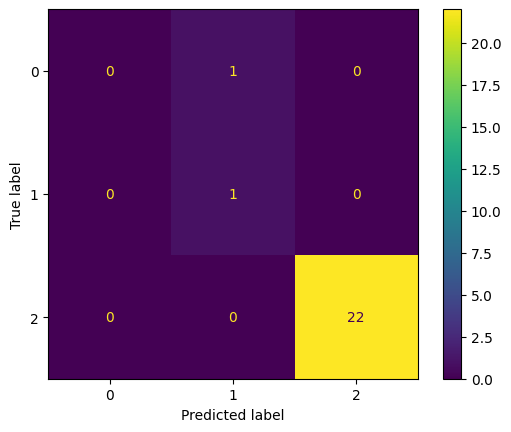

In [69]:
# visualize confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=svm_cm).plot();

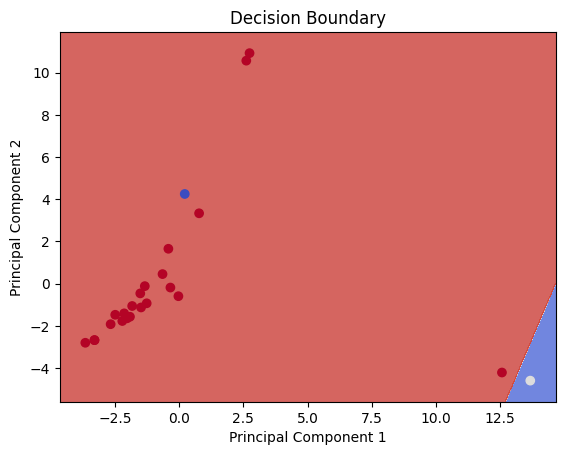

In [70]:
# import dependencies
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# plot decision boundary
def plot_decision_boundary(X, y, model):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    model.fit(X_pca, y)

    h = .02  # step size in the mesh
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # plot training points
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Decision Boundary')

    plt.show()

# plot decision boundary
plot_decision_boundary(X_test_scaled, y_test, svm_model)

In [63]:
# end the SparkSession
spark.stop()